# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [135]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import max as smax
from pyspark.sql.functions import countDistinct, regexp_extract, when

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
sparkify_data = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

I am going to start with some general analysis of the dataset. We need to understand the structure of data we are working with. First of all, let me check the schema of the data and the row example.

In [4]:
sparkify_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
sparkify_data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

How many rows do we have in total?

In [6]:
print("Dataset contains {0} rows".format(sparkify_data.count()))

Dataset contains 286500 rows


So we have a dataset consisting of 286500 rows and 18 columns. Let's dig deeper in available features.

It's quite obvious that there are several text features which can not be used as categorical due to huge amount of different possible values. Text features are: "artist", "firstName", "lastName", "location", "song". Assuming those are just names, we can suppose they don't have much value for model building.

In [7]:
sd_valid = sparkify_data.dropna(how = "any", subset = ["userId", "sessionId"])
sd_valid.count()

286500

In [8]:
sd_valid = sparkify_data.filter(sparkify_data["userId"] != "")
sd_valid.count()

278154

Nice to see there are nu null missed values for "userId" and "sessionId". But there are a lot of values having empry string instead of userId. No point keeping those.

In [9]:
sparkify_data = sparkify_data.filter(sparkify_data.userId != '')

What about categorical variables? looks like we've got quite a few.

In [10]:
sparkify_data.select("auth").dropDuplicates().sort("auth").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [11]:
sparkify_data.filter(sparkify_data.auth == 'Cancelled').take(3)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18'),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32'),
 Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, la

Cancel value seem to only appear at Cancellation Confirmation page, so no extra information here. I will not use this variable further.

In [12]:
sparkify_data.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Information about pages visited by user is definitely going to be one of the most important sources for frature engineering.

In [13]:
sparkify_data.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



Free users can only cancel service, while paid ones can either downgrade to free or cancel.

In [14]:
sparkify_data.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



I dont think this one is going to be itneresting for feature engineering.

What we have left? "Gender" is somthing characterizing the user himself, definitely to be used. "ItemInSession" can be used to track the whole session, same as "length". "Registration" does not seem to be too informative. "UserAgent" - who knows, maybe we can extract something useful here. "Status" - what if there are a lot of errors which can be connected to the users?

Now that we have some general knowledge about the dataset, it's time to turn it into something more valuable for model building. Let me start with defining Churn users. Those would be the ones cancelling the service or downgrading to free tier.

In [15]:
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' or x == 'Submit Downgrade' else 0, IntegerType())
sparkify_data = sparkify_data.withColumn("churn", churn_event("page"))

In [16]:
windowval = Window.partitionBy("userId")
sparkify_data = sparkify_data.withColumn("churn_user", smax(col("churn")).over(windowval))

In [17]:
sparkify_data.filter(sparkify_data.churn_user == 0).select("userId").dropDuplicates().count()

133

In [18]:
sparkify_data.filter(sparkify_data.churn_user == 1).select("userId").dropDuplicates().count()

92

I have first only marked events which are treated as churn, then all the records for churn and non-churn users.

Dataset is well balanced. 

Now I am going to analyze behavior of users belonging to two different groups and hopefully find something I can further use as features.

I see the "page" data as the largest possible source for potential features. 

I am starting with simply counting number of each page attendance for every user in the dataset. In order to make this analysis more descriptive I will create a pandas dataset and build some graphs. Dataframe will consist on some aggregational numbers, so it will be pretty small even for a large dataset, I don't see any issues with storing it in a variable.

In [19]:
pages = ['Add Friend', 'Add to Playlist', 'Error', 'Help', 'Home', 'NextSong', 'Roll Advert', \
         'Save Settings', 'Settings', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up']

In [20]:
sparkify_df = sparkify_data.filter(col("page").isin(pages)).groupby(["userId", "page"]) \
    .count().toPandas()

In [21]:
sparkify_df.head()

,userId,page,count
0,88,Home,85
1,88,NextSong,2045
2,13,Add to Playlist,37
3,87,Home,56
4,59,Add Friend,16


For every user-page pair I've counted the anount of records. I also want to know what group user belongs to.

In [22]:
user_churn = sparkify_data.select(["userId", "churn_user"]).dropDuplicates().toPandas()

The dataframe is now in "melt" view, let me pivot it, merge with "churn" column and clean from nulls.

In [23]:
pages_summary = sparkify_df.pivot(index = "userId", columns = "page", values = "count")

In [24]:
pages_summary.head()

page,Add Friend,Add to Playlist,Error,Help,Home,NextSong,Roll Advert,Save Settings,Settings,Submit Upgrade,Thumbs Down,Thumbs Up
userId,,,,,,,,,,,,
10,12.0,9.0,NaN,1.0,30.0,673.0,1.0,1.0,7.0,NaN,4.0,37.0
100,49.0,61.0,3.0,18.0,105.0,2682.0,25.0,5.0,11.0,1.0,27.0,148.0
100001,2.0,3.0,1.0,1.0,11.0,133.0,14.0,NaN,1.0,NaN,2.0,8.0
100002,1.0,5.0,NaN,NaN,6.0,195.0,3.0,NaN,NaN,NaN,NaN,5.0
100003,NaN,2.0,NaN,1.0,7.0,51.0,9.0,NaN,NaN,NaN,NaN,3.0


In [25]:
pages_summary.fillna(0, inplace=True)

In [26]:
pages_summary = pages_summary.merge(user_churn, on='userId')

In [27]:
pages_summary.head()

,userId,Add Friend,Add to Playlist,Error,Help,Home,NextSong,Roll Advert,Save Settings,Settings,Submit Upgrade,Thumbs Down,Thumbs Up,churn_user
0,10,12.0,9.0,0.0,1.0,30.0,673.0,1.0,1.0,7.0,0.0,4.0,37.0,0
1,100,49.0,61.0,3.0,18.0,105.0,2682.0,25.0,5.0,11.0,1.0,27.0,148.0,1
2,100001,2.0,3.0,1.0,1.0,11.0,133.0,14.0,0.0,1.0,0.0,2.0,8.0,1
3,100002,1.0,5.0,0.0,0.0,6.0,195.0,3.0,0.0,0.0,0.0,0.0,5.0,0
4,100003,0.0,2.0,0.0,1.0,7.0,51.0,9.0,0.0,0.0,0.0,0.0,3.0,1


This looks like and old good dataframe now! Easiest I can do is comparing meand for all possible actions (pages).

In [28]:
pages_summary.groupby(["churn_user"]).mean()

,Add Friend,Add to Playlist,Error,Help,Home,NextSong,Roll Advert,Save Settings,Settings,Submit Upgrade,Thumbs Down,Thumbs Up
churn_user,,,,,,,,,,,,
0,16.255639,24.285714,1.052632,5.383459,37.285714,853.857143,11.857143,1.240602,5.744361,0.488722,8.609023,47.045113
1,22.989130,35.826087,1.217391,8.021739,55.684783,1245.054348,25.608696,1.576087,8.152174,1.021739,15.228261,68.413043


Looks like pretty significant difference can be observed in most of them. I will also build a scatter plot matrix using different colors for user groups.

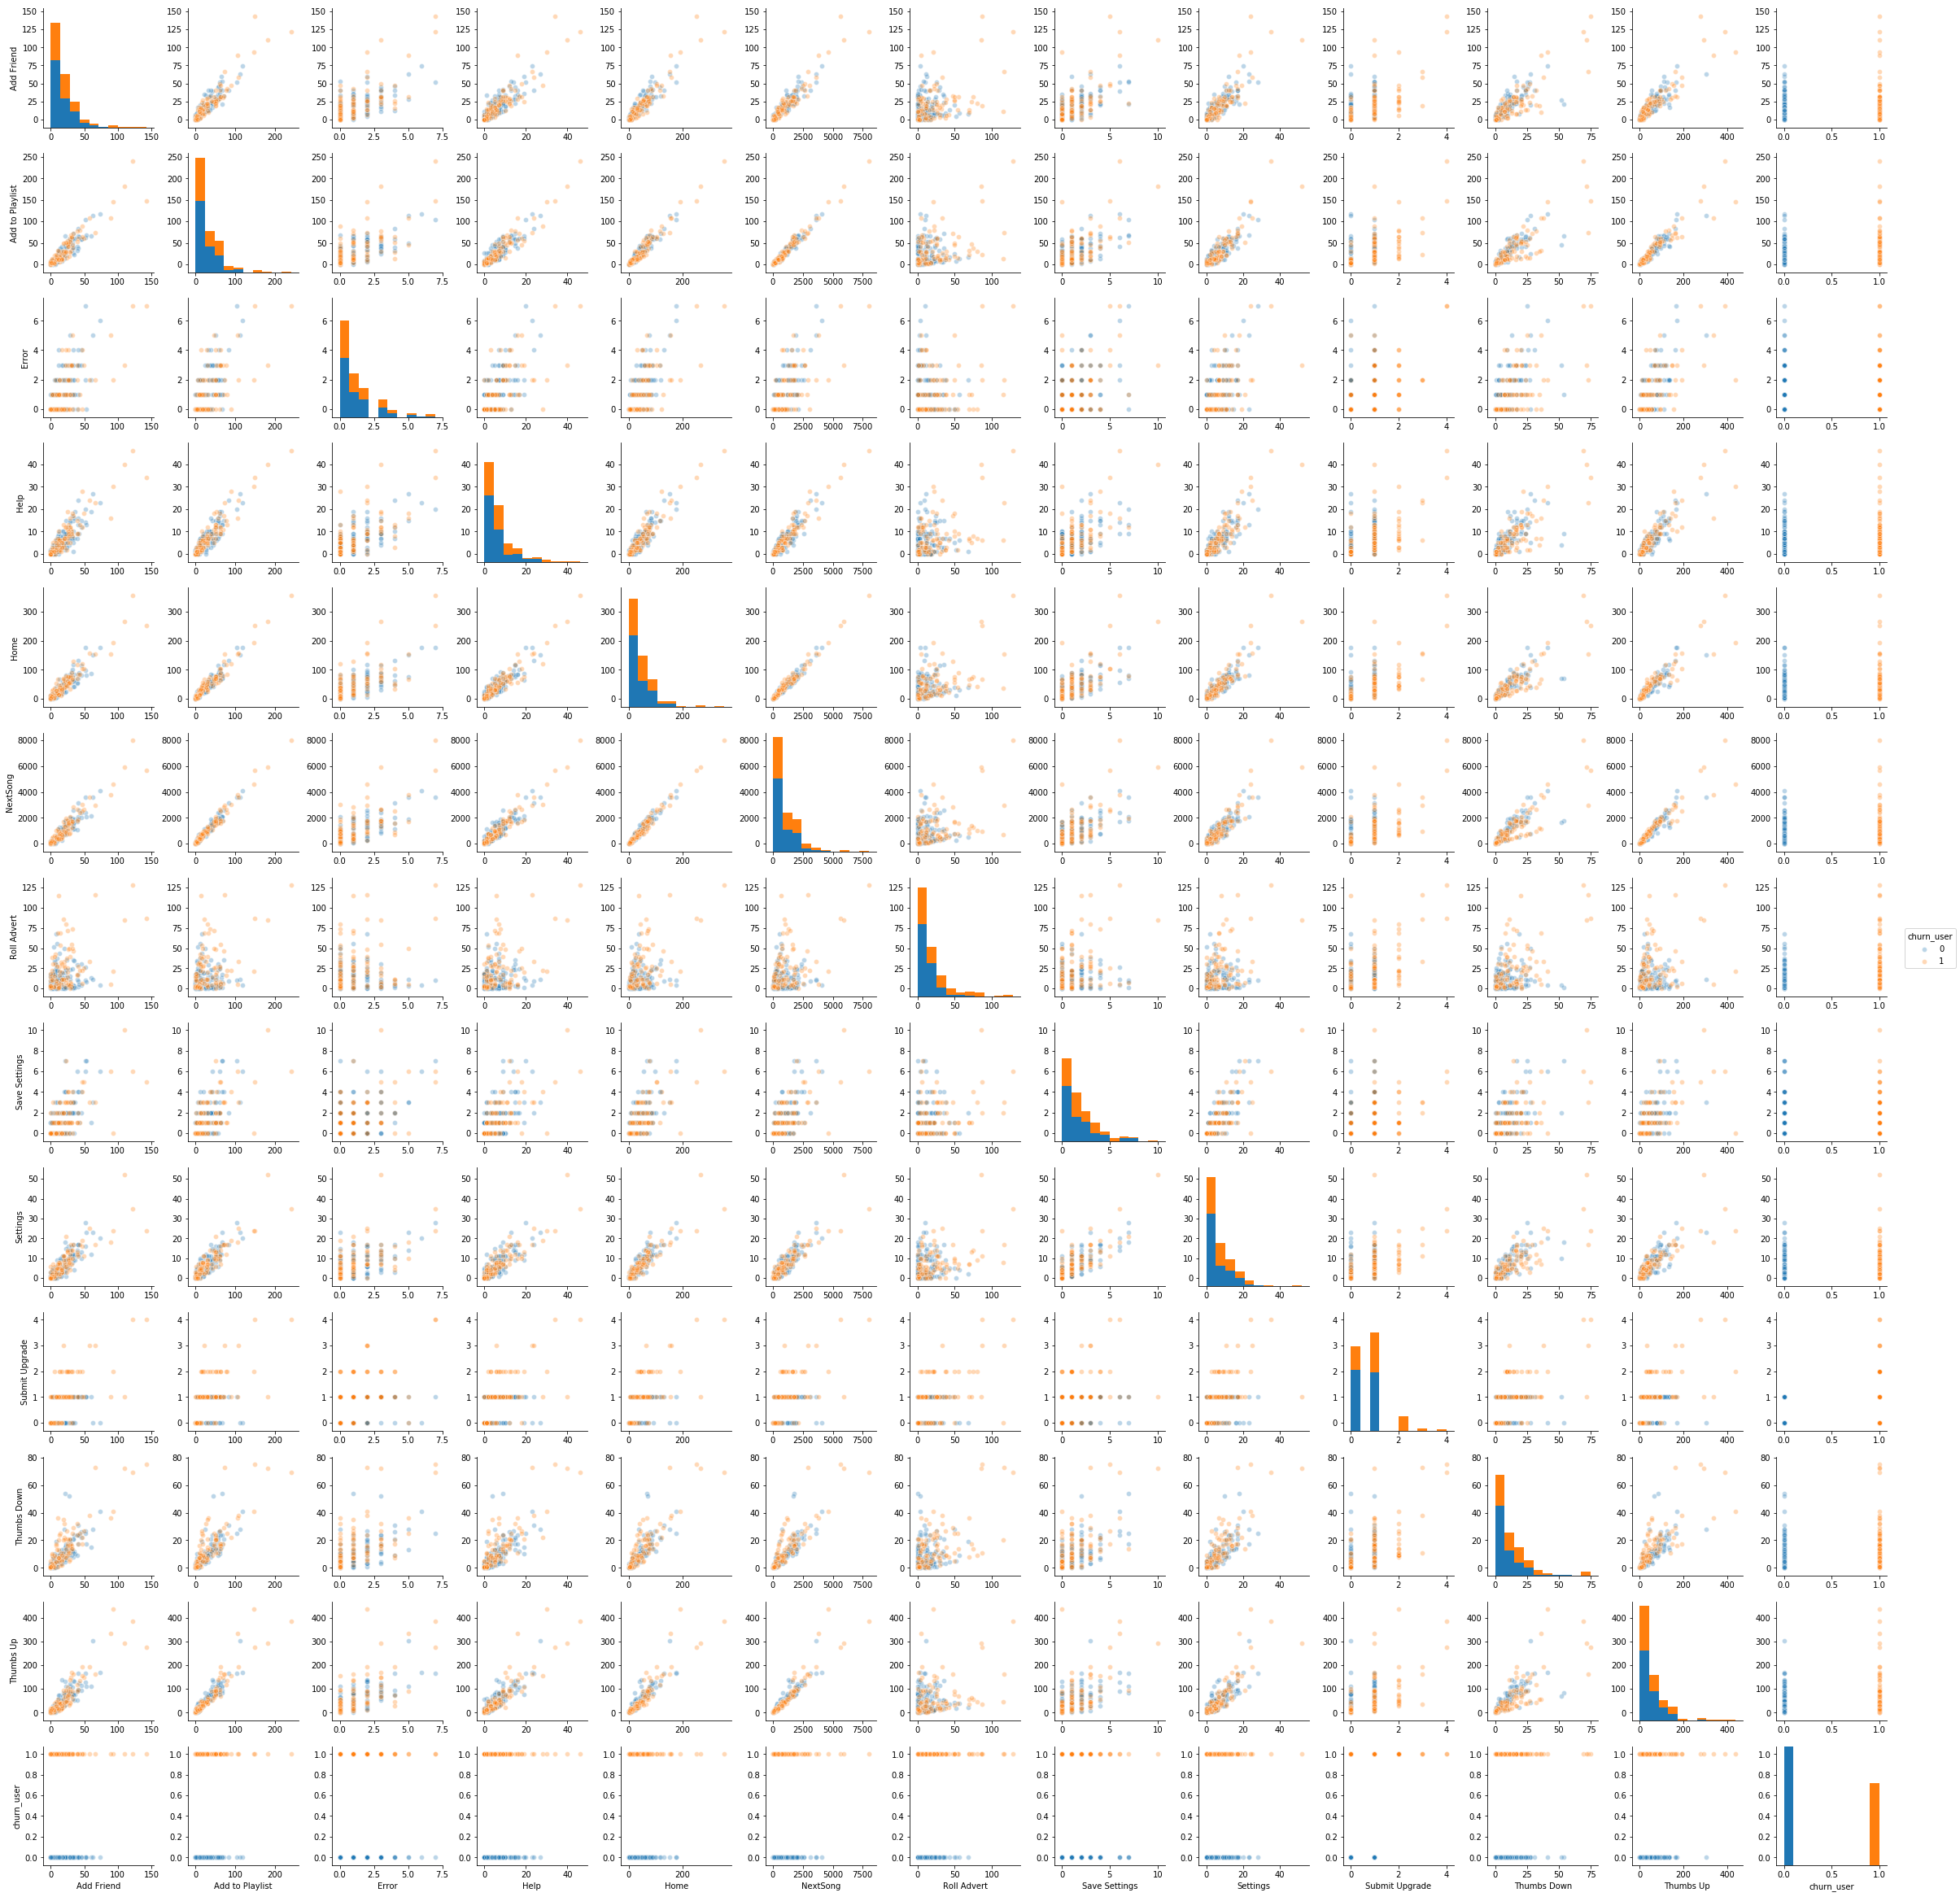

In [29]:
sns.pairplot(pages_summary.drop(columns=["userId"]), hue='churn_user', plot_kws={'alpha': 0.3})

Closeness to 0 for some actions makes it a bit hard to analyze. Nevertheless, this data is definitely going to be used.

No doubt "gender" column will be included too. This is almost the only (except for name and location) data piece describing the user him(her)self.

In [30]:
sparkify_data.select(["userId", "gender", "churn_user"]).dropDuplicates().groupby(["churn_user", "gender"]).count().show()

+----------+------+-----+
|churn_user|gender|count|
+----------+------+-----+
|         1|     F|   43|
|         0|     M|   72|
|         1|     M|   49|
|         0|     F|   61|
+----------+------+-----+



We've got length for songs played, why not use those? Maybe users who listen more tend to churn less?

In [31]:
sparkify_data.select(["userId", "length", "churn_user"]).groupby(["churn_user", "userId"]).sum("length") \
    .groupby("churn_user").avg("sum(length)").show()

+----------+------------------+
|churn_user|  avg(sum(length))|
+----------+------------------+
|         1| 310145.8052251084|
|         0|212723.36891646608|
+----------+------------------+



Not quite what I was expecting to be honest, on the average "churn" users tend to listen more. Still, difference seem to be pretty impressive.

Next we can extract is sessionIds. For each user I want to get average and maximum length of the session.

In [32]:
sparkify_data.select(["userId", "sessionId", "churn_user"]).groupby(["churn_user", "userId", "sessionId"]).count() \
    .groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+-----------------+
|churn_user|  avg(avg(count))|
+----------+-----------------+
|         1|82.98641012443774|
|         0|86.10151882274668|
+----------+-----------------+



In [33]:
sparkify_data.select(["userId", "sessionId", "churn_user"]).groupby(["churn_user", "userId", "sessionId"]).count() \
    .groupby(["churn_user", "userId"]).max("count").groupby("churn_user").avg("max(count)").show()

+----------+-----------------+
|churn_user|  avg(max(count))|
+----------+-----------------+
|         1|291.0326086956522|
|         0|268.6766917293233|
+----------+-----------------+



In [34]:
sessions_max_lengths = sparkify_data.select(["userId", "sessionId", "churn_user"]).groupby(["churn_user", "userId", "sessionId"]).count() \
    .groupby(["churn_user", "userId"]).max("count").toPandas()
sessions_max_lengths.head()

,churn_user,userId,max(count)
0,0,100010,112
1,0,200002,152
2,1,125,11
3,0,124,519
4,1,51,599


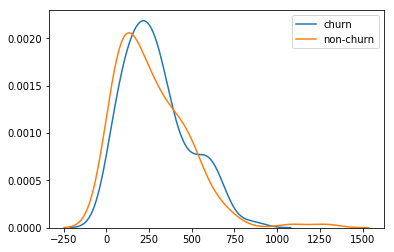

In [35]:
sns.kdeplot(sessions_max_lengths['max(count)'][sessions_max_lengths['churn_user'] == 1], 
            label='churn')
sns.kdeplot(sessions_max_lengths['max(count)'][sessions_max_lengths['churn_user'] == 0], 
            label='non-churn')

Distriutions of maximum session length seem to differ. Not too much, but it's quite observable.

As all the rows in the dataset have timestamp, we can generate time-based statistics. Data we have only covers 2 month, so I will stick to days. First, we need to mark each row with month and day.

In [36]:
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)

In [37]:
sparkify_data = sparkify_data.withColumn("month", get_month(sparkify_data.ts))
sparkify_data = sparkify_data.withColumn("day", get_day(sparkify_data.ts))

In [38]:
sparkify_data.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, churn_user=0, month='10', day='8')

Next, I will gather aggregated statistics based on date. How much actions does user perform daily? 

In [39]:
sparkify_data.select(["userId", "month", "day", "churn_user"]).groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+-----------------+
|churn_user|  avg(avg(count))|
+----------+-----------------+
|         1| 82.8226520787324|
|         0|74.54174950660935|
+----------+-----------------+



In [40]:
avg_actions_per_day = sparkify_data.select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").toPandas()
avg_actions_per_day.head()

,churn_user,userId,avg(count)
0,0,114,85.944444
1,1,12,106.400000
2,1,103,119.090909
3,0,200012,42.000000
4,0,82,102.450000


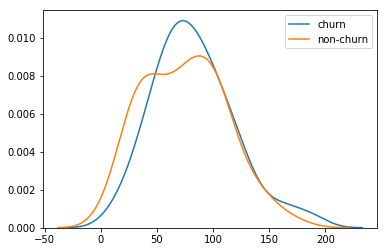

In [41]:
sns.kdeplot(avg_actions_per_day['avg(count)'][avg_actions_per_day['churn_user'] == 1], 
            label='churn')
sns.kdeplot(avg_actions_per_day['avg(count)'][avg_actions_per_day['churn_user'] == 0], 
            label='non-churn')

Again, weirdly, "churn" suers tend to be more active. What about concrete actions like listeting to a song or adding a friend?

In [42]:
sparkify_data.filter(sparkify_data.page == 'NextSong').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1| 68.26173643764719|
|         0|61.766273417375395|
+----------+------------------+



In [43]:
avg_playsong_per_day = sparkify_data.filter(sparkify_data.page == 'NextSong'). \
    select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").toPandas()
avg_playsong_per_day.head()

,churn_user,userId,avg(count)
0,0,114,76.000000
1,1,12,86.700000
2,1,103,107.300000
3,0,200012,33.000000
4,0,82,94.722222


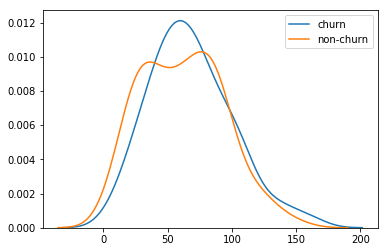

In [44]:
sns.kdeplot(avg_playsong_per_day['avg(count)'][avg_playsong_per_day['churn_user'] == 1], 
            label='churn')
sns.kdeplot(avg_playsong_per_day['avg(count)'][avg_playsong_per_day['churn_user'] == 0], 
            label='non-churn')

In [45]:
sparkify_data.filter(sparkify_data.page == 'Add Friend').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1| 2.636175399280173|
|         0|2.7418091469324066|
+----------+------------------+



In [46]:
sparkify_data.filter(sparkify_data.page == 'Add to Playlist').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1|2.9256237521496447|
|         0|2.6979759726527557|
+----------+------------------+



In [47]:
sparkify_data.filter(sparkify_data.page == 'Thumbs Up').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+-----------------+
|churn_user|  avg(avg(count))|
+----------+-----------------+
|         1|4.506563960862261|
|         0|4.252070779972376|
+----------+-----------------+



In [204]:
sparkify_data.filter(sparkify_data.page == 'Error').select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "month", "day"]) \
    .count().groupby(["churn_user", "userId"]).avg("count").groupby("churn_user").avg("avg(count)").show()

+----------+------------------+
|churn_user|   avg(avg(count))|
+----------+------------------+
|         1|1.0933333333333335|
|         0|1.0950248756218908|
+----------+------------------+



For me differences for all the pages, except 'Next song', and maybe 'Add to playlist' do not look meaningful.

Next, I want to check how much active days user has per month. Assuming we only have data for October and November (and very little for December, I will ignore it here), I will count those separately: active days in October and active days in November.

In [76]:
sparkify_data.filter(sparkify_data.month == 10).select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "day"]).count().groupby(["churn_user", "userId"]).count(). \
    groupby("churn_user").avg("count").show()

+----------+------------------+
|churn_user|        avg(count)|
+----------+------------------+
|         1|10.076086956521738|
|         0| 6.586776859504132|
+----------+------------------+



In [77]:
sparkify_data.filter(sparkify_data.month == 11).select(["userId", "month", "day", "churn_user"]) \
    .groupby(["churn_user", "userId", "day"]).count().groupby(["churn_user", "userId"]).count(). \
    groupby("churn_user").avg("count").show()

+----------+-----------------+
|churn_user|       avg(count)|
+----------+-----------------+
|         1|9.193548387096774|
|         0|            6.608|
+----------+-----------------+



This looks like something we can use.

Last thing I want to investigate is device user runs the application from. I'll start with extracting data from "userAgent" columns.

In [123]:
sparkify_data = sparkify_data.withColumn("device", regexp_extract(sparkify_data.userAgent, r"\((.+?);", 1))

In [124]:
sparkify_data.select("device").dropDuplicates().show()

+--------------+
|        device|
+--------------+
|          iPad|
|           X11|
|Windows NT 6.3|
|        iPhone|
|Windows NT 6.2|
|     Macintosh|
|    compatible|
|Windows NT 6.0|
|Windows NT 6.1|
|              |
+--------------+



Couple of these values need to be checked.

In [125]:
sparkify_data.filter(sparkify_data.device == '').select("userAgent").dropDuplicates().collect()

[Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"')]

In [126]:
sparkify_data.filter(sparkify_data.device == 'X11').select("userAgent").dropDuplicates().collect()

[Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"')]

In [127]:
sparkify_data.filter(sparkify_data.device == 'compatible').select("userAgent").dropDuplicates().collect()

[Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)')]

Alright, empty value always comes from Windows PC, as well as 'compatible'. 'X11' is Linux PC.

In [128]:
sparkify_data = sparkify_data.withColumn("device_new", when(col("device") \
        .isin(["Windows NT 6.3", "Windows NT 6.2", "Windows NT 6.0, Windows NT 6.1", "compatible", ""]), "Windows PC") \
        .when(sparkify_data.device == "X11", "Linux PC").when(sparkify_data.device == "Macintosh", "Mac PC") \
        .when(col("device").isin(["iPad", "iPhone"]), "iOS device"))

In [129]:
sparkify_data.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, churn_user=0, month='10', day='8', device='iPhone', device_new='iOS device')

In [131]:
devices_df = sparkify_data.select(["userId", "churn_user", "device_new"]).dropDuplicates().sort("userId").toPandas()

In [133]:
devices_df.head()

,userId,churn_user,device_new
0,10,0,Mac PC
1,100,1,None
2,100001,1,Mac PC
3,100002,0,None
4,100003,1,None


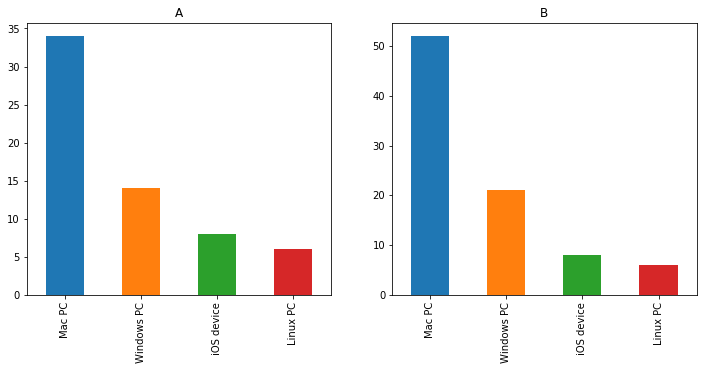

In [138]:
pylab.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
plt.title('A')
devices_df['device_new'][devices_df['churn_user'] == 1].value_counts().plot(kind='bar')
ax1 = plt.subplot(1, 2, 2)
plt.title('B')
devices_df['device_new'][devices_df['churn_user'] == 0].value_counts().plot(kind='bar')

Does not looks like distributions are significantly different for two groups of users.

Overall I believe the needed features have been found and I can move to feature extraction now.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.